In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

Download Data

In [57]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(url, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [58]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [60]:
df['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [61]:
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

In [62]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()


* Apply the log transform to median_house_value.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the train_test_split function and set the random_state parameter to 1.

<AxesSubplot:>

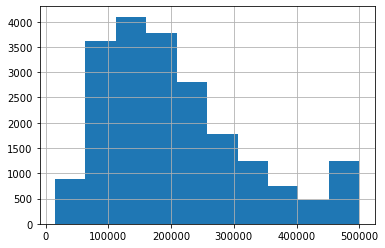

In [63]:
df['median_house_value'].hist()

<AxesSubplot:>

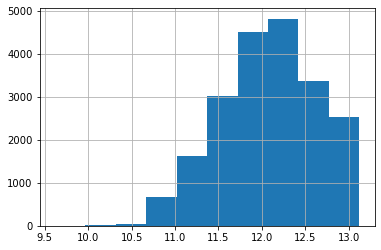

In [64]:
np.log1p(df['median_house_value']).hist()

In [65]:
df['median_house_value'] = np.log1p(df['median_house_value'])

#@ SPLITTING THE DATASET FOR TRAINING AND TEST:

In [27]:
X = df.drop('median_house_value', axis=1)
Y = df['median_house_value']

In [66]:
X_train,X_test= train_test_split(df,test_size=0.2,random_state=1)
X_train,X_val= train_test_split(X_train,test_size=0.2,random_state=1)

In [67]:
X_train.shape,X_test.shape,X_val.shape

((13209, 10), (4128, 10), (3303, 10))

In [68]:
y_train = X_train['median_house_value']
y_val = X_val['median_house_value']
y_test = X_test['median_house_value']

In [69]:
X_train = X_train.drop('median_house_value', axis=1)
X_val = X_val.drop('median_house_value', axis=1)
X_test = X_test.drop('median_house_value', axis=1)

In [70]:
X_train.shape,X_test.shape,X_val.shape

((13209, 9), (4128, 9), (3303, 9))

In [71]:
X_train['ocean_proximity'] = lb.fit_transform(X_train['ocean_proximity'])


In [72]:
lb.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [73]:
X_val['ocean_proximity'] = lb.transform(X_val['ocean_proximity'])
X_test['ocean_proximity'] = lb.transform(X_test['ocean_proximity'])

#@ IMPLEMENTATION OF DICTVECTORIZER:

* We will use DictVectorizer to turn train and validation into matrices.

In [74]:
columns =  X_train.columns.tolist()

In [75]:
columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [80]:
train_dicts = X_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=True)
x_train = dv.fit_transform(train_dicts)
#
val_dicts = X_val[columns].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [81]:
x_train.shape

(13209, 9)

## Question 1

Let's train a decision tree regressor to predict the median_house_value variable.

Train a model with max_depth=1.

In [82]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth =1)
dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=1)

#@ INSPECTION:
* Which feature is used for splitting the data?

In [84]:
r = export_text(dt, feature_names=columns,decimals=0, show_weights=True)
print(r)

|--- total_bedrooms <= 4
|   |--- value: [12]
|--- total_bedrooms >  4
|   |--- value: [12]



* Feature used for split : **total_bedrooms**

# Question 2

* Train a random forest model with these parameters:

        - n_estimators=10
        - random_state=1
        - n_jobs=-1 (optional-to make training faster)

In [88]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10,
                           random_state=1,
                           n_jobs=-1)

rf.fit(x_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [89]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(x_val)
print(f"Mean squared error = {np.sqrt(mean_squared_error(y_pred,y_val))}")

Mean squared error = 0.24680701770998806


# Question 3

#### Now, let's experiment with the n_estimators parameter.

* Try different values of this parameter from 10 to 200 with step 10.
* Set random_state to 1.
* Evaluate the model on the validation dataset.

In [90]:
for estimator in range(10,200,10):
    rf = RandomForestRegressor(n_estimators=estimator,
                           random_state=1,
                           n_jobs=-1)
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_val)
    print(f"Mean squared error for n_estimator :{estimator} = {np.sqrt(mean_squared_error(y_pred,y_val))}")
    

Mean squared error for n_estimator :10 = 0.24680701770998806
Mean squared error for n_estimator :20 = 0.23947743650412634
Mean squared error for n_estimator :30 = 0.2352382200826087
Mean squared error for n_estimator :40 = 0.23449602462266284
Mean squared error for n_estimator :50 = 0.23404925508178062
Mean squared error for n_estimator :60 = 0.23298228427169954
Mean squared error for n_estimator :70 = 0.2325458153528997
Mean squared error for n_estimator :80 = 0.2322109206362102
Mean squared error for n_estimator :90 = 0.2319432262377783
Mean squared error for n_estimator :100 = 0.23145737065165095
Mean squared error for n_estimator :110 = 0.23167895389751614
Mean squared error for n_estimator :120 = 0.2315413127749453
Mean squared error for n_estimator :130 = 0.23125807196499124
Mean squared error for n_estimator :140 = 0.23141389513657837
Mean squared error for n_estimator :150 = 0.2314705967135564
Mean squared error for n_estimator :160 = 0.2313998828782527
Mean squared error for n

* After which value of n_estimators does RMSE stop improving?

* Answer: 100

# Question 4

#### Let's select the best max_depth:

* Try different values of max_depth: [10, 15, 20, 25].
* For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
* Fix the random seed: random_state=1.

In [91]:
for depth  in [10,15,20,25]:   
    for estimator in range(10,200,10):
        rf = RandomForestRegressor(max_depth=depth,
                                     n_estimators=estimator,
                                    random_state=1,
                                    n_jobs=-1)
        rf.fit(x_train,y_train)
        y_pred = rf.predict(x_val)
        print(f"Mean squared error for max_depth: {depth} n_estimator :{estimator} = {np.sqrt(mean_squared_error(y_pred,y_val))}")

Mean squared error for max_depth: 10 n_estimator :10 = 0.2561665566824039
Mean squared error for max_depth: 10 n_estimator :20 = 0.2516328707632263
Mean squared error for max_depth: 10 n_estimator :30 = 0.24919139854630012
Mean squared error for max_depth: 10 n_estimator :40 = 0.24833949644709177
Mean squared error for max_depth: 10 n_estimator :50 = 0.24848107482909695
Mean squared error for max_depth: 10 n_estimator :60 = 0.24802599010666418
Mean squared error for max_depth: 10 n_estimator :70 = 0.24768190030543352
Mean squared error for max_depth: 10 n_estimator :80 = 0.2472944847323516
Mean squared error for max_depth: 10 n_estimator :90 = 0.24713295464342017
Mean squared error for max_depth: 10 n_estimator :100 = 0.24690885799263268
Mean squared error for max_depth: 10 n_estimator :110 = 0.24709169796899946
Mean squared error for max_depth: 10 n_estimator :120 = 0.24696072724955112
Mean squared error for max_depth: 10 n_estimator :130 = 0.246858743265845
Mean squared error for max

* What's the best max_depth:

* Answer: 20

# Question 5

* We can extract feature importance information from tree-based models.

* At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

* In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

*For this homework question, we'll find the most important feature:

* Train the model with these parametes:

        - n_estimators=10,
        - max_depth=20,
        - random_state=1,
        - n_jobs=-1 (optional)
* Get the feature importance information from this model

In [92]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(x_train,y_train)
print(rf.feature_importances_)

[0.02048543 0.03782731 0.10498295 0.09726556 0.48536074 0.18336421
 0.02979307 0.0185275  0.02239322]


In [93]:
fi = pd.DataFrame({'feature': dv.feature_names_, 'importance': rf.feature_importances_})

In [95]:
fi = fi.sort_values(by='importance',ascending=False)
fi

,feature,importance
4,median_income,0.485361
5,ocean_proximity,0.183364
2,latitude,0.104983
3,longitude,0.097266
1,housing_median_age,0.037827
6,population,0.029793
8,total_rooms,0.022393
0,households,0.020485
7,total_bedrooms,0.018528


* What's the most important feature?

* Answer: **median_income**

# Question 6

* Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost.
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

    - xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [97]:
import xgboost as xgb
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
# Parameter dictionary specifying base learner
param =  {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
  
xgb_r = xgb.train(params = param, dtrain = dtrain, num_boost_round = 100)
pred = xgb_r.predict(dval)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_val,pred))
print("RMSE : % f" %(rmse))

RMSE :  0.228872


In [100]:
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity',
 'population',
 'total_bedrooms',
 'total_rooms']

* Now, change eta first to 0.1 and then to 0.01.
* Which eta leads to the best RMSE score on the validation dataset?



In [98]:
# Parameter dictionary specifying base learner
param =  {  
    'eta': 0.1,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
  
xgb_r = xgb.train(params = param, dtrain = dtrain, num_boost_round = 100)
pred = xgb_r.predict(dval)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_val,pred))
print("RMSE : % f" %(rmse))

RMSE :  0.232547


In [99]:
# Parameter dictionary specifying base learner
param =  {  
    'eta': 0.01,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
  
xgb_r = xgb.train(params = param, dtrain = dtrain, num_boost_round = 100)
pred = xgb_r.predict(dval)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_val,pred))
print("RMSE : % f" %(rmse))

RMSE :  4.267588


* eta 0.3 RMSE = 0.228872
* eta 0.1 RMSE = 0.232547
* eta 0.01 RMSE = 4.267588
* **ANSWER**: 0.3